In [95]:
import os # dizin okuma
import logging # detaylı bir print / log yazdırma kütüphanesi
from tqdm import tqdm
from PIL import Image


In [96]:
# loggingin farklı seviyeleri var. örneğin, INFO, DEBUG, ERROR, WARNING
# Bu seviyelerde ekrana print etmeyi ve log dosyalarını bir yere kayıt altına almayı sağlıyor.
# logging settings
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [97]:
# Dizinlerle çalışacağımız için, önce böyle bir dizin var mı yok mu onu kontrol edebileceğimiz bir fonksiyon yazalım.

def check_is_dir(path):
    if not os.path.isdir(path):
        raise ValueError(f"Provided path {path} is not a directory")
    return True

In [98]:
# Dizin altındaki tüm fotoğrafları tarayıp, istenilen uzantıdakileri toplasın.
def filter_images(list_of_files):
    valid_extension = {".jpeg", ".png", ".jpg", ".webp"}
    return [file for file in list_of_files if any (file.endswith(ext) for ext in valid_extension)]

In [99]:
# Okunan dosyaları bir pilow formatında kayıt altına almamız gerekiyor.
def load_image(image_path):
    image = Image.open(image_path).convert("RGB") #Image fonksiyonu görseli okuyor.
    return image

In [100]:
def read_images_from_dir(dir_path):
    """
    Bu fonksiyon, check_is_dir, filter_images, load_image fonksiyonları ile okuma işlemi gerçekleştirir.
    :param dir_path:
    :return:
    """
    check_is_dir(dir_path) # path kontrolü
    files = os.listdir(dir_path) # path içerisinde yer alan tüm dosyaları listeler
    image_files = filter_images(files) # dosyaları uzantılarına göre filtreler.
    image_paths = [os.path.join(dir_path, file) for file in image_files] # listdir sadece dosya isimlerini aldığı için burada bir absolute path alıyoruz.

    images = [load_image(image_path) for image_path in tqdm(image_paths)] # tqdm ile total okuma süresi vs, progression görmüş olacağız.
    logging.info(f"Loaded {len(images)} images from {dir_path}")
    return images

In [101]:
loaded_images = read_images_from_dir("raw_images/cat")

100%|██████████| 217/217 [00:18<00:00, 11.54it/s]
2024-06-15 23:18:01,450 - INFO - Loaded 217 images from raw_images/cat


In [102]:
# Fotoğrafları başarılı bir şekilde okuduk. Logging info formatladığımız şekilde geldi. Önce tarih, sonra tür (INFO), ardından info olarak tanımladığımız mesajımız geldi.
# Şimdi rescaling (resize) işlemi yapacağız. Örneğin scraping sırasında çok büyük fotoğraflar geldiyse bunların boyutunu ayarlayabiliriz. Fotoğrafların çok küçük olması da mümkün; bu eğitimde 224x224, 128x128 boyutuna küçülteceğiz fotoğraları ama boyutları bundan küçük olan fotoğraflar da olabilir. Onları direkt verisetinden atacağız.

In [103]:
def max_resolution_rescale(image, max_width, max_height):
    width, height = image.size
    if width > max_width or height > max_height:
        ratio = min(max_width / width, max_height/height)
        new_width = int(width * ratio)
        new_height = int(height * ratio)
        image = image.resize((new_width, new_height), Image.LANCZOS)
    return image

In [104]:
max_size = 1024

resized_images = list(map(lambda x: max_resolution_rescale(x, max_size, max_size), tqdm(loaded_images)))

100%|██████████| 217/217 [00:11<00:00, 19.60it/s]


In [105]:
def min_resulation_filter(image, min_width, min_height):
    width, height = image.size
    return width >= min_width and height >= min_height

In [106]:
min_size = 224

filtered_images = list(filter(lambda x: min_resulation_filter(x, min_size, min_size), tqdm(loaded_images)))


100%|██████████| 217/217 [00:00<00:00, 567433.90it/s]


In [107]:
len(filtered_images)

202

In [108]:
# Fotoğrafların hepsini resize ettik. Boyutu büyük olanları 1024x1024 boyutuna küçülttük, boyutu 224x224 küçük olanları ise filtreledik.

In [109]:
# Farklı shape, aspect ratiolarda, farklı çözünürlüklerde olan fotoğraflarımızı crop edeceğiz.

In [110]:
import matplotlib.pyplot as plt

In [111]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

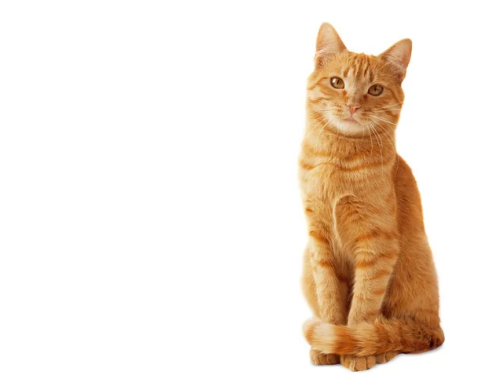

In [112]:
plot_image(filtered_images[14])

In [113]:
def center_crop(image, new_width, new_height):
    width, height = image.size
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    cropped_image = image.crop((left, top, right, bottom))
    logging.info(f"Center cropped image to {new_width} x {new_height}")
    return cropped_image

In [114]:
min_size = 224

2024-06-15 23:18:12,927 - INFO - Center cropped image to 224 x 224


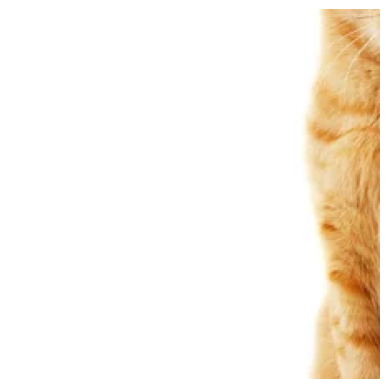

In [115]:
plot_image(center_crop(filtered_images[14], min_size, min_size))

In [116]:
from smartcrop import detect

In [117]:
cropped_image = detect(filtered_images[15], square=True)
#plot_image(cropped_image)

In [118]:
cropped_images = list(map(lambda x: detect(x, square=True, crop=True), tqdm(filtered_images)))

100%|██████████| 202/202 [06:09<00:00,  1.83s/it]


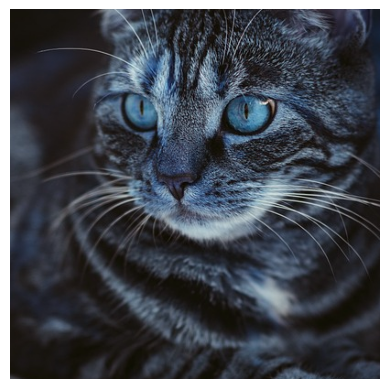

In [119]:
plot_image(cropped_images[18])

In [120]:
# Preprocess işlemleri bitti. Büyük imagelar küçüldü, çok küçükler filtrelendi ve tüm image croplandı. Bunları processed olarak kayıt edeceğiz.

Saving Photos

In [121]:
import numpy as np
def save_image(image, save_path, logging=True):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    if not isinstance(image, Image.Image):
        raise ValueError('Input image must be a numpy array or PIL image')
    if image.mode == "RGB":
        # Bazen imagelar RGBE olabiliyor, ya da background ya da alfası olan CMYK imagelar olabiliyor. Onu kontrol ediyoruz.
        image = image.convert("RGB")

    image.save(save_path)
    if logging:
        logging.info(f"Saved image to {save_path}")

In [122]:
def create_drectory(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
        print(f"Directory created: {dir_path}")
    else:
        print(f"Directory already exists {dir_path}")

In [123]:
def save_images_to_dir(images, dir_path):
    create_drectory(dir_path)
    check_is_dir(dir_path)

    for idx, image in tqdm(enumerate(images, 1)):
        save_path = os.path.join(dir_path, f"Image_{idx}.png")
        save_image(image, save_path, logging=False)
    return True

In [126]:
# create_direcitory fonksiyonunu os.makedirs olarak oluşturduğumuz için, / ile sonrasında vereceğimiz alt directoryleri de oluşturuyor (çoğul eki gibi)
save_images_to_dir(cropped_images, "processed_images/cat")

Directory created: processed_images/cat


202it [02:45,  1.22it/s]


True

# Embeddinglerin Alınması

In [2]:
# Clustering işlemini embeddingler ile yaparak, alakalı ve alakasız fotoğrafları ayrı klasörlere kaydedebiliyor olacağız.
# Unsupervised teknikler kullanarak yapacağız. 250 fotoğrafı el ile temizleyebiliriz ancak elde binlerce fotoğraf olduğunda bu mümkün olmayacaktır.